"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import sys
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [2]:
# Some poisson spiking
length = 100
states = 3
nrns = 10
tastes = 4
trials = 20
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random((tastes,trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[...,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)

print(true_tau.shape)

(4, 20, 3)


In [3]:
state_inds = np.concatenate([np.zeros((tastes,trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:,:-1]

print(true_tau.shape)
print(state_inds.shape)

(4, 19, 3)
(4, 20, 4)


In [4]:
true_lambda = np.random.random((tastes,nrns,states))
print(true_lambda.shape)

(4, 10, 3)


In [5]:
true_r = np.zeros((tastes,trials, nrns, length))

for taste in range(tastes):
    for trial_num in range(trials):
        for state_num in range(states):
            true_r[taste,trial_num,:,state_inds[taste,trial_num,state_num]:state_inds[taste,trial_num,state_num+1]] = \
                            true_lambda[taste,:,state_num][:,np.newaxis]
        
data_array = np.random.random(true_r.shape) < true_r        


In [6]:
print(data_array.shape)
true_r_long = np.reshape(true_r, (-1,*true_r.shape[2:]))
data_array_long = np.reshape(data_array, (-1,*data_array.shape[2:]))
print(data_array_long.shape)
taste_labels = np.repeat(np.arange(tastes),trials)
print(taste_labels)

(4, 20, 10, 100)
(80, 10, 100)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]


/media/bigdata/firing_space_plot/ephys_data/visualize.py:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  vmin = min_val[nrn], vmax = max_val[nrn])


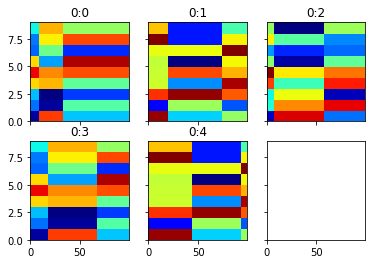

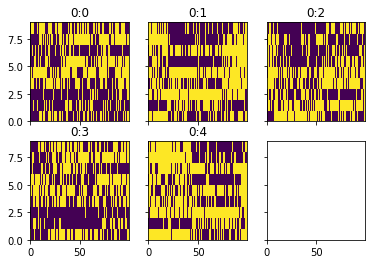

In [7]:
trial_count = 5
trial_inds = np.random.choice(np.arange(trials*tastes),5)
visualize.firing_overview(true_r_long[trial_inds]);
visualize.firing_overview(data_array_long[trial_inds], cmap='viridis');

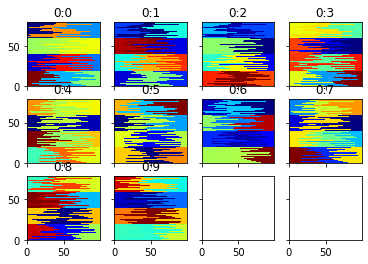

In [8]:
visualize.firing_overview(true_r_long.swapaxes(0,1));

In [9]:
mean_vals = np.array([np.mean(x,axis=-1)                                   
             for x in np.array_split(data_array,states,axis=-1)]).T              
mean_vals = np.mean(mean_vals,axis=1)                                        
mean_vals += 0.01 # To avoid zero starting prob  
print(mean_vals.shape)

(10, 4, 3)


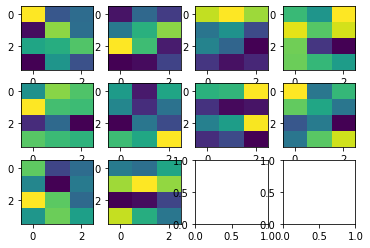

In [10]:
fig,ax = visualize.gen_square_subplots(mean_vals.shape[0])
for this_dat, this_ax in zip(mean_vals, ax.flatten()):
    this_ax.imshow(this_dat,aspect='auto')

In [32]:
with pm.Model() as model:
    # Finite, but somewhere on the lower end, Beta prior
    a_lambda = 2
    b_lambda = 5
    lambda_latent = pm.Beta('lambda', 
                                    a_lambda, b_lambda, 
                                    shape = (nrns,tastes,states),
                                      testval = mean_vals + 1e-3)
    
    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (tastes*trials,states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [31]:
lambda_latent.tag.test_value.shape

(10, 4, 3)

In [33]:
tau.tag.test_value.shape

(80, 2)

In [12]:
with model:
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((tastes*trials,1,length)),weight_stack],axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((tastes*trials,1,length))],axis=1)
    weight_stack = weight_stack*inverse_stack
    weight_stack = tt.tile(weight_stack[:,:,None,:], (1,1,nrns,1))
    
    lambda_latent = tt.repeat(lambda_latent, trials, axis=1)
    lambda_latent = tt.tile(lambda_latent[...,None], (1,1,1,length))
    lambda_latent = lambda_latent.dimshuffle(1,2,0,3)
    lambda_ = tt.sum(lambda_latent * weight_stack, axis=1)

In [13]:
weight_stack.tag.test_value.shape

(80, 3, 10, 100)

In [14]:
lambda_latent.tag.test_value.shape

(80, 3, 10, 100)

In [15]:
lambda_.tag.test_value.shape

(80, 10, 100)

In [16]:
data_array_long.shape

(80, 10, 100)

In [17]:
# plt.imshow(weight_stack.tag.test_value[0,:,0],aspect='auto');

In [18]:
# print(f'lambda_latent : {lambda_latent.tag.test_value.shape}')
# print(f'weight_stack : {weight_stack.tag.test_value.shape}') # Positions of changepoint
# #print(f'lambda_latent[taste_labels] : {lambda_latent.tag.test_value[taste_labels].shape}')

In [19]:
# lambda_latent_test = lambda_latent.tag.test_value.copy()
# #lambda_latent_test = np.tile(lambda_latent_test, (1,2,1))
# lambda_latent_test = np.repeat(lambda_latent_test, trials, axis=1)
# lambda_latent_test = np.moveaxis(lambda_latent_test, 0, -1)
# lambda_latent_test.shape

In [20]:
# lambda_latent_test = np.tile(lambda_latent_test[...,None], (1,1,1,length))
# lambda_latent_test.shape

In [21]:
# weight_stack_test = weight_stack.tag.test_value
# weight_stack_test = np.tile(weight_stack_test[:,:,None], (1,1,nrns,1))
# weight_stack_test.shape

In [22]:
# plt.imshow(lambda_latent_test[...,1,0,:],aspect='auto', interpolation='nearest');

In [23]:
# lambda_ = np.sum(lambda_latent_test * weight_stack_test, axis=1)

In [24]:
# print(data_array_long.shape)

/media/bigdata/firing_space_plot/ephys_data/visualize.py:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  vmin = min_val[nrn], vmax = max_val[nrn])


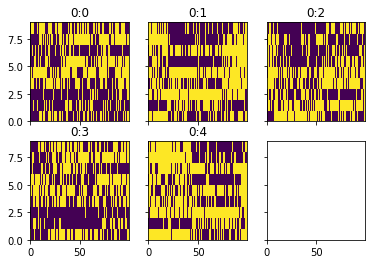

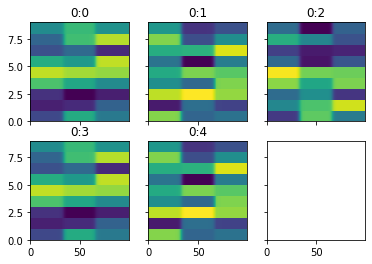

In [25]:
visualize.firing_overview(data_array_long[trial_inds],cmap='viridis');
visualize.firing_overview(lambda_.tag.test_value[trial_inds], cmap='viridis');

In [26]:
with model:
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_array_long)

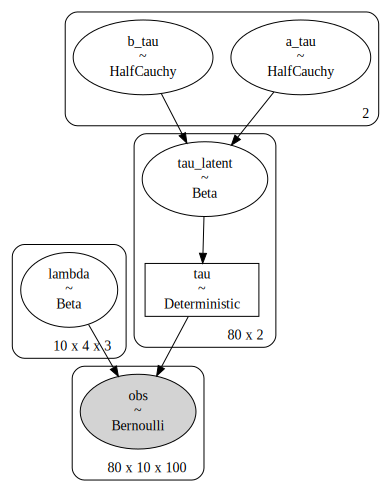

In [27]:
pm.model_to_graphviz(model)

In [28]:
with model:
    #approx = pm.fit(n=fit, method=pm.ADVI('full-rank'))
    #trace = approx.sample(draws=samples)
    trace = pm.sample()


/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, b_tau, a_tau, lambda]


ValueError: Not enough samples to build a trace.

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [ ]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

In [ ]:
trial_count = 5
trial_inds = np.random.choice(np.arange(trials),5)

In [ ]:
visualize.firing_overview(np.concatenate(true_r,axis=0)[trial_inds],cmap='viridis');
visualize.firing_overview(np.mean(ppc['obs'],axis=0)[trial_inds],cmap='viridis');

In [ ]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
print(tau.shape)
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
print(mode_tau.shape)

In [ ]:
fig,ax = plt.subplots(3,trial_count,sharex=True,figsize=(20,10))
for trial_num,this_trial_ind in enumerate(trial_inds):
    ax[0,trial_num].imshow(np.concatenate(true_r,axis=0)[this_trial_ind],aspect='auto', interpolation='nearest')
    ax[1,trial_num].imshow(np.concatenate(data_array,axis=0)[this_trial_ind],aspect='auto', interpolation='nearest')
    
    for tau_num, this_tau in enumerate(tau[:,this_trial_ind].T):
        ax[2,trial_num].hist(this_tau,bins=50)
        ax[0,trial_num].vlines(mode_tau[this_trial_ind,tau_num],-0.5,nrns-0.5,color='red',alpha=1,linewidth=5, linestyles='dashed')